In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import itertools

import nltk 
from nltk.corpus import sentiwordnet as swn 

from afinn import Afinn
from plotnine import ggplot, aes, geom_bar, labs, xlim

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel


ModuleNotFoundError: No module named 'plotnine'

In [ ]:
df = pd.read_csv('GTA_V_cleaned.csv')
df.head()


NameError: name 'pd' is not defined

In [4]:
afinn = Afinn()
afinn.score('love')



-3.0

In [11]:
test = df['review'][10]
test_text = ' '.join(test)
test_text

'g o o d'

In [12]:
score = afinn.score(test_text)
print(score)

0.0


In [14]:
def calculate_sentiment_score(text):
    return afinn.score(text)
df['sentiment_score'] = df['cleaned_text'].apply(calculate_sentiment_score)
df['sentiment_score'].describe()

count    18596.000000
mean         1.519413
std          5.105954
min       -270.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        594.000000
Name: sentiment_score, dtype: float64

In [16]:
lower_outl = df.loc[df['sentiment_score']==-270]
print(lower_outl['review'])

15103    I HATE CAYO SETUPS I HATE CAYO SETUPS I HATE C...
Name: review, dtype: object


c:\Users\thech\anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_count : Removed 168 rows containing non-finite values.
c:\Users\thech\anaconda3\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


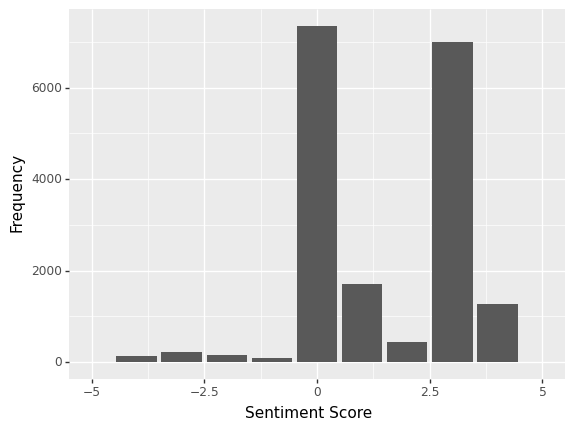

<ggplot: (176221977067)>

In [17]:
(ggplot(df, aes(x='sentiment_score')) 
 + geom_bar() 
 + labs(x="Sentiment Score", y="Frequency") 
 + xlim(-5, 5)
)

### Overall sentiment using AFINN shows that game rarely gets below a nuetral (0) but also has just as many users with positive sentiment as nuetral


In [18]:
negative_reviews = df[df['sentiment_score'] < 0]
sample_neg_reviews = negative_reviews.sample(n=10, random_state=42)
sample_neg_reviews

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,preprocessed_text,cleaned_text,sentiment_score
9519,124418522,english,HARD WORK :),1666792862,1666792862,True,0,0,0.000000,0,...,76561199278310073,2,4,13117,0,1189,2023-02-12 05:58:08,"[('hard', 'JJ'), ('work', 'NN')]","['hard', 'work']",-1.0
2172,132100657,english,games fucking stupid,1675393502,1675393502,False,0,0,0.000000,0,...,76561198280852245,67,8,3456,13,2013,2023-03-02 22:18:43,"[('game', 'NN'), ('fucking', 'VBG'), ('stupid'...","['game', 'fucking', 'stupid']",-6.0
14652,120450528,english,good shit,1660235011,1660235011,True,1,0,0.522059,0,...,76561198973435170,49,1,2887,0,1884,2022-09-16 10:05:42,"[('good', 'JJ'), ('shit', 'NN')]","['good', 'shit']",-1.0
8005,126191167,english,fire,1669179815,1669179815,True,0,0,0.000000,0,...,76561199277186573,2,1,3349,1,841,2023-02-24 20:08:34,"[('fire', 'NN')]",['fire'],-2.0
10378,123680561,english,Its fucking GTA,1665495462,1665495462,True,0,1,0.000000,0,...,76561199066110491,37,8,6076,0,1457,2022-12-21 21:46:41,"[('fucking', 'VBG'), ('gta', 'NN')]","['fucking', 'gta']",-4.0
18512,117981808,english,FIRE ASS GAME,1656665462,1656665462,True,0,0,0.000000,0,...,76561199051836276,18,7,17272,0,196,2023-02-11 19:23:07,"[('fire', 'NN'), ('as', 'IN'), ('game', 'NN')]","['fire', 'as', 'game']",-2.0
1584,132636006,english,I LIKE THE NIGGA IN MY SLAVE,1676134358,1676134358,True,0,0,0.000000,0,...,76561199228670232,10,5,7273,3010,2317,2023-03-09 16:38:55,"[('like', 'IN'), ('nigga', 'NNS'), ('slave', '...","['like', 'nigga', 'slave']",-1.0
1865,132346809,english,GOOFY,1675732434,1675732434,True,1,0,0.523810,0,...,76561199123484492,24,4,379,0,257,2023-02-08 17:06:54,"[('goofy', 'NN')]",['goofy'],-2.0
4364,130334790,english,fire,1673083195,1673083195,True,0,0,0.000000,0,...,76561199188714027,6,1,14115,0,9109,2023-01-16 21:09:06,"[('fire', 'NN')]",['fire'],-2.0
1560,132648592,english,bad game,1676144152,1676144152,False,0,0,0.000000,0,...,76561199162477857,23,1,30713,0,30242,2023-02-21 17:37:55,"[('bad', 'JJ'), ('game', 'NN')]","['bad', 'game']",-3.0


In [20]:
for index, row in sample_neg_reviews.iterrows():
    print(f"Review: {''.join(row['cleaned_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: ['hard', 'work']
Sentiment score: -1.0

Review: ['game', 'fucking', 'stupid']
Sentiment score: -6.0

Review: ['good', 'shit']
Sentiment score: -1.0

Review: ['fire']
Sentiment score: -2.0

Review: ['fucking', 'gta']
Sentiment score: -4.0

Review: ['fire', 'as', 'game']
Sentiment score: -2.0

Review: ['like', 'nigga', 'slave']
Sentiment score: -1.0

Review: ['goofy']
Sentiment score: -2.0

Review: ['fire']
Sentiment score: -2.0

Review: ['bad', 'game']
Sentiment score: -3.0



In [21]:
positive_reviews = df[df['sentiment_score']>0]
sample_pos_reviews = positive_reviews.sample(n=10, random_state=42)
for index, row in sample_pos_reviews.iterrows():
    print(f"Review: {''.join(row['cleaned_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: ['yummy']
Sentiment score: 3.0

Review: ['nice']
Sentiment score: 3.0

Review: ['good', 'game']
Sentiment score: 3.0

Review: ['good', 'game']
Sentiment score: 3.0

Review: ['good']
Sentiment score: 3.0

Review: ['good']
Sentiment score: 3.0

Review: ['fun']
Sentiment score: 4.0

Review: ['good']
Sentiment score: 3.0

Review: ['nice', 'game']
Sentiment score: 3.0

Review: ['like']
Sentiment score: 2.0



### SentiWordNet

In [22]:
swn_words = [word[0] for row in df['preprocessed_text'] for word in row]
synsets = swn.senti_synsets('good', 'a')  # 'a' indicates that the word is an adjective
pos_score = neg_score = obj_score = 0

In [23]:
for syn in synsets:
    pos_score += syn.pos_score()
    neg_score += syn.neg_score()
    obj_score += syn.obj_score()

if len(list(synsets)) >0:
    pos_score /= len(synsets)
    neg_score /= len(synsets)
    obj_score /= len(synsets)
print(f"Positive score: {pos_score:.2f}, Negative score: {neg_score:.2f}, Objective score: {obj_score:.2f}") #Retirating what previously seen, overall postive from all collected

Positive score: 13.00, Negative score: 0.12, Objective score: 7.88


In [24]:
preprocessed_docs = [doc.split() for doc in df['cleaned_text']]
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(text) for text in preprocessed_docs]
texts = [eval(text) for text in df['cleaned_text']]
coherence_dict = gensim.corpora.Dictionary(texts)
num_topics = 8

In [25]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=42,
                                            passes=10,
                                            per_word_topics=True)

In [31]:
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}')
    keywords = " ".join(word for word, _ in lda_model.show_topic(idx, topn=10))
    print(f'Top Keywords: {keywords}\n')


Topic: 0
Top Keywords: 'game'] ['good', 'nice', ['like'] ['cool', 'good', ['game'] ['j'] ['yea'] ['perfect']

Topic: 1
Top Keywords: ['good'] ['love', ['k'] 'gta', ['pp'] ['w', ['gta', 'v'] 'online'] ['fucking',

Topic: 2
Top Keywords: ['nice'] ['gud'] 'fun'] ['epic'] ['yes', ['yeah'] ['classic'] 'fun', ['asd'] ['fun',

Topic: 3
Top Keywords: ['yes'] ['hi'] ['h'] ['like', ['bad'] ['mid'] ['wow'] ['funny', ['amazing'] 'car']

Topic: 4
Top Keywords: ['w'] ['great'] ['ok'] 'trevor', ['g'] ['ball'] ['l'] 'grec', ['play'] ['goated']

Topic: 5
Top Keywords: 'game', ['best', 'game'] ['e'] 'ever'] ['shit', ['f'] 'play'] 'play', ['sus']

Topic: 6
Top Keywords: ['fun'] ['gta'] ['love'] 'hate', 'cayo', 'setup', ['best'] ['noice'] ['ye'] ['lol']

Topic: 7
Top Keywords: 'game'] ['great', ['nice', ['cool'] ['gg'] 'good'] ['game', 'gta'] ['op'] ['n']



In [33]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: nan


c:\Users\thech\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
c:\Users\thech\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
c:\Users\thech\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
